<a href="https://colab.research.google.com/github/Steiner-bot/Learn_sympy/blob/main/CoursePaperNNCrypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Курсовая работа


In [1]:
!pip install theano
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install lasagne==0.1
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

  Using cached https://github.com/Theano/Theano/archive/master.zip
  Created wheel for Theano: filename=Theano-1.0.5+unknown-cp37-none-any.whl size=2667281 sha256=e5a37f61f2e066cab00235b7dbfe720cfa55539707559b5abc22c55dc855d730
  Stored in directory: /tmp/pip-ephem-wheel-cache-ynrkw4rb/wheels/33/73/96/0ed263c62a86e2485ea634e0d3ae8169d50fd66e3b252541db
Successfully built Theano
  Found existing installation: Theano 1.0.5+unknown
    Uninstalling Theano-1.0.5+unknown:
      Successfully uninstalled Theano-1.0.5+unknown
Processing /root/.cache/pip/wheels/a5/8e/31/b4cae7e5507f8582e77d7f5cf2815be8820ccacfa0519ca60c/Lasagne-0.1-cp37-none-any.whl
  Found existing installation: Lasagne 0.2.dev1
    Uninstalling Lasagne-0.2.dev1:
      Successfully uninstalled Lasagne-0.2.dev1
  Using cached https://github.com/Lasagne/Lasagne/archive/master.zip
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp37-none-any.whl size=122797 sha256=0d5d372308a3b2e9a5bfb515ffbfdbe2001288663ddeeb1a47eb4da980c7

In [2]:
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
from lasagne.updates import adam

### Определение необходимых функций и классов

In [3]:
def get_activation(inp, act_fn, name):
    if act_fn == 'tanh':
        return T.tanh(inp)
    elif act_fn == 'relu':
        return T.nnet.relu(inp)
    elif act_fn == 'sigmoid':
        return T.nnet.sigmoid(inp)
    else:
        print ('Note: no valid activation specified for ' + name)
        return inp
 
def get_source(source):
    """Функция, используемая для получения тензора теано 
    из класса, если класс был передан в"""
    if 'Layer' in source.__class__.__name__:
        return source.output
    return source
    
def get_weights(in_dim, out_dim, name):
    """Функция для получения разделяемой матрицы W, 
    инициализированной Glorot"""
    W_val = np.asarray(\
        np.random.uniform(low=-np.sqrt(6. / (in_dim + out_dim)), 
                          high=np.sqrt(6. / (in_dim + out_dim)),
                          size=(in_dim, out_dim)), dtype=theano.config.floatX)
    return theano.shared(value=W_val, name=name, borrow=True)
 
def get_bias(d, name):
    """Функция для получения общей переменной смещения"""
    b_values = np.zeros((d,), dtype=theano.config.floatX)
    b = theano.shared(value=b_values, name=name, borrow=True)
    return b

def get_all_params(layers):
    """Функция для извлечения всех параметров из списка слоев"""
    out = []
    for l in layers:
        for p in l.params:
            out.append(p)
    return out

In [4]:
class ConvLayer:
    def __init__(self, source, filter_shape, image_shape, stride,
                 act_fn, border_mode='full', name='conv'):
        assert image_shape[1] == filter_shape[1]
                             
        self.image_shape = image_shape
        self.filter_shape = filter_shape
        self.stride = stride
        self.border_mode = border_mode
        self.name = name
        self.act_fn = act_fn
        
        self.parent = source
        self.source = get_source(source)
 
        #количество входных карт функций высота фильтра, ширина фильтра
        # входы для каждого скрытого блока
        fan_in = np.prod(filter_shape[1:])
        # каждая единица нижнего уровня получает градиент от:
        # "количество выходных карт функций * высота фильтра * ширина фильтра"
        fan_out = (filter_shape[0] * np.prod(filter_shape[2:]))
        # инициализировать веса случайными весами
        W_bound = np.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(
            np.asarray(
                np.random.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                dtype=theano.config.floatX
            ),
            borrow=True,
            name=name + '_W'
        )
 
        # смещение представляет собой одномерный тензор - одно смещение на выходную карту признаков
        b_values = np.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True, name=name + '_b')
        # свертка входных карт объектов с фильтрами
        conv_out = T.nnet.conv2d(
            input=self.source,
            filters=self.W,
            filter_shape=self.filter_shape,
            input_shape=self.image_shape,
            border_mode=self.border_mode,
            subsample=self.stride
        )
        
        # Вывод расчетов
        self.output_pre_activ = conv_out + self.b.dimshuffle('x', 0, 'x', 'x')
        # Активировать это
        self.output = get_activation(self.output_pre_activ,
                                     act_fn=self.act_fn,
                                     name=self.name)
 
        self.params = [self.W, self.b]

In [5]:
class HiddenLayer:
    def __init__(self, source, input_size, hidden_size, name, act_fn):
        self.parent = source
        self.source = get_source(source)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.name = name
        self.act_fn = act_fn
        # Получите веса и смещения
        self.W = get_weights(self.input_size, self.hidden_size, 'W_' + name)
        self.b = get_bias(self.hidden_size, 'b_' + name)
        # Вывод расчетов
        self.output_pre_activ = T.dot(self.source, self.W) + \
                                self.b.dimshuffle('x', 0)
        # Activate it
        self.output = get_activation(self.output_pre_activ,
                                     act_fn=self.act_fn,
                                     name=self.name)
        self.params = [self.W, self.b]

In [6]:
# Параметры
batch_size = 512
msg_len = 16
key_len = 16
comm_len = 16
 
# флаг, чтобы исключить сверточные слои из сетей.
skip_conv = False

In [7]:
def gen_data(n=batch_size, msg_len=msg_len, key_len=key_len):
    """Функция для генерации n случайных сообщений и ключей"""
    return (np.random.randint(0, 2, size=(n, msg_len))*2-1).\
                astype(theano.config.floatX),\
           (np.random.randint(0, 2, size=(n, key_len))*2-1).\
                astype(theano.config.floatX)
 
def assess(pred_fn, n=batch_size, msg_len=msg_len, 
           key_len=key_len):
    """Function to assess a batch by eye (see what the 
    errors look like)"""
    msg_in_val, key_val = gen_data(n, msg_len, key_len)
    return np.round(np.abs(msg_in_val[0:n] - \
           pred_fn(msg_in_val[0:n], key_val[0:n])), 0)

def err_over_samples(err_fn, n=batch_size):
    """Функция для получения ошибки"""
    msg_in_val, key_val = gen_data(n)
    return err_fn(msg_in_val[0:n], key_val[0:n])

In [8]:
class StandardConvSetup():
    def __init__(self, reshaped_input, name='unnamed'):
        
        self.name = name
        self.conv_layer1 = ConvLayer(reshaped_input,
                                     filter_shape=(2, 1, 4, 1), #num outs, num ins, size
                                     image_shape=(None, 1, None, 1),
                                     stride=(1,1),
                                     name=self.name + '_conv1',
                                     border_mode=(2,0),
                                     act_fn='relu')
        
        self.conv_layer2 = ConvLayer(self.conv_layer1, 
                                     filter_shape=(4, 2, 2, 1),
                                     image_shape=(None, 2, None, 1),
                                     stride=(2,1),
                                     name=self.name + '_conv2',
                                     border_mode=(0,0),
                                     act_fn='relu')
        
        self.conv_layer3 = ConvLayer(self.conv_layer2, 
                                     filter_shape=(4, 4, 1, 1),
                                     image_shape=(None, 4, None, 1),
                                     stride=(1,1),
                                     name=self.name + '_conv3',
                                     border_mode=(0,0),
                                     act_fn='relu')
        
        self.conv_layer4 = ConvLayer(self.conv_layer3, 
                                     filter_shape=(1, 4, 1, 1),
                                     image_shape=(None, 4, None, 1),
                                     stride=(1,1),
                                     name=self.name + '_conv4',
                                     border_mode=(0,0),
                                     act_fn='tanh')
        
        self.output = self.conv_layer4.output
        self.layers = [self.conv_layer1, self.conv_layer2, 
                       self.conv_layer3, self.conv_layer4]
        self.params = []
        for l in self.layers:
            self.params += l.params

### Подготовка нейронной сети

In [9]:
# Тензорные переменные для сообщения и ключа
msg_in = T.matrix('msg_in')
key = T.matrix('key')
 
# Ввод Алисы - это соединение сообщения и ключа
alice_in = T.concatenate([msg_in, key], axis=1)
 
# Скрытый слой Алисы
alice_hid = HiddenLayer(alice_in,
                        input_size=msg_len + key_len,
                        hidden_size=msg_len + key_len,
                        name='alice_to_hid',
                        act_fn='relu')
if skip_conv:
    alice_conv = HiddenLayer(alice_hid,
                             input_size=msg_len + key_len,
                             hidden_size=msg_len,
                             name='alice_hid_to_comm',
                             act_fn='tanh')
    alice_comm = alice_conv.output
else:
    
    alice_conv_in = alice_hid.output.reshape((batch_size, 1, msg_len + key_len, 1))
    # Сверточные слои Алисы
    alice_conv = StandardConvSetup(alice_conv_in, 'alice')
    
    alice_comm = alice_conv.output.reshape((batch_size, msg_len))
 
# Ввод Боба - это соединение сообщения Алисы и ключа
bob_in = T.concatenate([alice_comm, key], axis=1)
# Он расшифровывает, используя скрытый слой и свёрточную сеть согласно Алисе.
bob_hid = HiddenLayer(bob_in, 
                      input_size=comm_len + key_len,
                      hidden_size=comm_len + key_len,
                      name='bob_to_hid',
                      act_fn='relu')
if skip_conv:
    bob_conv = HiddenLayer(bob_hid,
                           input_size=comm_len + key_len,
                           hidden_size=msg_len,
                           name='bob_hid_to_msg',
                           act_fn='tanh')
    bob_msg = bob_conv.output
else:
    bob_conv_in = bob_hid.output.reshape((batch_size, 1, comm_len + key_len, 1))
    bob_conv = StandardConvSetup(bob_conv_in, 'bob')
    bob_msg = bob_conv.output.reshape((batch_size, msg_len))
 
# Ева видит сообщение Алисы Бобу, но не ключ
# Она получает дополнительный скрытый слой, чтобы попытаться научиться расшифровывать сообщение.
eve_hid1 = HiddenLayer(alice_comm, 
                       input_size=comm_len,
                       hidden_size=comm_len + key_len,
                       name='eve_to_hid1',
                       act_fn='relu')
                          
eve_hid2 = HiddenLayer(eve_hid1, 
                       input_size=comm_len + key_len,
                       hidden_size=comm_len + key_len,
                       name='eve_to_hid2',
                       act_fn='relu')
 
if skip_conv:
    eve_conv = HiddenLayer(eve_hid2,
                           input_size=comm_len + key_len,
                           hidden_size=msg_len,
                           name='eve_hid_to_msg',
                           act_fn='tanh')
    eve_msg = eve_conv.output
else:
    eve_conv_in = eve_hid2.output.reshape((batch_size, 1, comm_len + key_len, 1))
    eve_conv = StandardConvSetup(eve_conv_in, 'eve')
    eve_msg = eve_conv.output.reshape((batch_size, msg_len))
 
# Функция потерь Евы - это норма L1 между истинным и восстановленным сообщением.
decrypt_err_eve = T.mean(T.abs_(msg_in - eve_msg))
 
# Функция потерь Боба - это норма L1 между истинным и восстановленным
decrypt_err_bob = T.mean(T.abs_(msg_in - bob_msg))
# --> Боб хочет, чтобы Ева могла угадывать только наугад.
loss_bob = decrypt_err_bob + (1. - decrypt_err_eve) ** 2.
 
 
# Получает все параметры для Боба и Алисы, обновлет, обучет и подготавливает функции
params   = {'bob' : get_all_params([bob_conv, bob_hid, 
                                    alice_conv, alice_hid])}
updates  = {'bob' : adam(loss_bob, params['bob'])}
err_fn   = {'bob' : theano.function(inputs=[msg_in, key],
                                    outputs=decrypt_err_bob)}
train_fn = {'bob' : theano.function(inputs=[msg_in, key],
                                    outputs=loss_bob,
                                    updates=updates['bob'])}
pred_fn  = {'bob' : theano.function(inputs=[msg_in, key], outputs=bob_msg)}
 
params['eve']   = get_all_params([eve_hid1, eve_hid2, eve_conv])
updates['eve']  = adam(decrypt_err_eve, params['eve'])
err_fn['eve']   = theano.function(inputs=[msg_in, key], 
                                  outputs=decrypt_err_eve)
train_fn['eve'] = theano.function(inputs=[msg_in, key], 
                                  outputs=decrypt_err_eve,
                                  updates=updates['eve'])
pred_fn['eve']  = theano.function(inputs=[msg_in, key], outputs=eve_msg)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Обучение сети

In [10]:
def train(bob_or_eve, results, max_iters, print_every, es=0., es_limit=100):
    """Функция для обучения Боба + Алисы или Евы в течение некоторого времени"""
    count = 0
    for i in range(max_iters):
        # Генерирует данные
        msg_in_val, key_val = gen_data()
        loss = train_fn[bob_or_eve](msg_in_val, key_val)
        results = np.hstack((results, 
                             err_fn[bob_or_eve](msg_in_val, key_val).sum()))
        if i % print_every == 0:
            print ('training loss:', loss)
        # Eранняя остановка, если мы видим низкую ошибку дешифрования
        if es and loss < es:
            count += 1
            if count > es_limit:
                break
    return np.hstack((results, np.repeat(results[-1], max_iters - i - 1)))
 
results_bob, results_eve = [], []
adversarial_iterations = 1
 
for i in range(adversarial_iterations):
    n = 2000
    print_every = 100
    print ('training bob and alice, run:', i+1)
    results_bob = train('bob', results_bob, n, print_every, es=0.01)
    print ('training eve, run:', i+1)
    results_eve = train('eve', results_eve, n, print_every, es=0.01)

training bob and alice, run: 1
training loss: 0.9993531108325979
training loss: 0.9146033801036713
training loss: 0.5948838235059638
training loss: 0.27261327706408534
training loss: 0.07799979097995809
training loss: 0.022966569003266928
training loss: 0.00873589441921234
training eve, run: 1
training loss: 1.0018088294062757
training loss: 0.8435351549559426
training loss: 0.2891606795668058
training loss: 0.05991325246276107
training loss: 0.028588407503051496
training loss: 0.017425748960855105
training loss: 0.012081052842895014
training loss: 0.008578623246524258


### Результаты

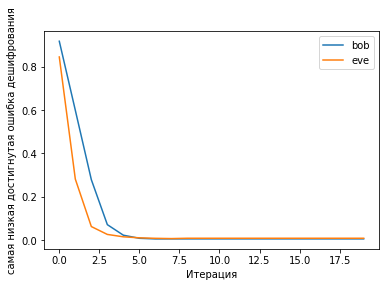

In [11]:
n = 100
# Постройка пезультатов
plt.plot([np.min(results_bob[i:i+n]) for i in np.arange(0, 
          len(results_bob), n)])
plt.plot([np.min(results_eve[i:i+n]) for i in np.arange(0, 
          len(results_eve), n)])
plt.legend(['bob', 'eve'])
plt.xlabel('Итерация')
plt.ylabel('самая низкая достигнутая ошибка дешифрования')
plt.show()